In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates
import os
pd.options.mode.copy_on_write = True

In [3]:
#Reading in raw data
Purchase_Orders = pd.read_csv(r'C:\Users\PurchaseOrders.csv')
Purchase_Order_Lines = pd.read_csv(r'C:\Users\PurchaseOrderLines.csv')

In [10]:
#Combining datasets to find orders by date
Orders_by_date = Purchase_Order_Lines.merge(Purchase_Orders,how='left',on='PurchaseOrderID')

In [6]:
#Selecting useful columns for analysis - Order date and quantity of orders
Orders_by_date2 = Orders_by_date[['OrderedOuters','OrderDate']]
print(Orders_by_date2.head(5))

   OrderedOuters   OrderDate
0             18  2013-01-01
1             21  2013-01-01
2             18  2013-01-01
3              8  2013-01-01
4              1  2013-01-01


In [9]:
#Summarising sales by month
Orders_by_date2['OrderDate'] = pd.to_datetime(Orders_by_date2['OrderDate'])
Orders_by_date2['OrderMonth'] = Orders_by_date2['OrderDate'].dt.floor('d')+pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
Order_data = Orders_by_date2.groupby(['OrderMonth'])['OrderedOuters'].sum()

print(Order_data.head(5))

OrderMonth
2013-01-01     8178
2013-02-01     7693
2013-03-01    14552
2013-04-01    25963
2013-05-01    40298
Name: OrderedOuters, dtype: int64


<Axes: title={'center': 'Dataframe plot'}, xlabel='OrderMonth'>

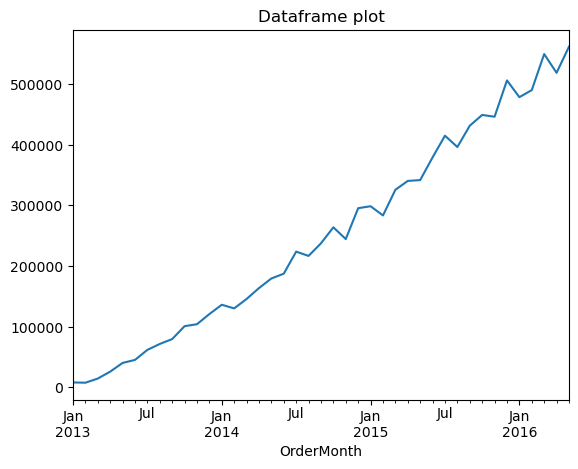

In [11]:
#Plotting the resultant 1d series
Order_data.plot(title = "Dataframe plot")

In [21]:
#We will carry out tests on a smaller subset of the data, acheived by filtering "order data"
startdate = pd.to_datetime("2013-01-01")
enddate = pd.to_datetime("2015-12-31")

In [25]:
#Filtering "order data" based on the dates set above
Train_data = Order_data[(Order_data.index>=startdate)&(Order_data.index<=enddate)]
print(Test_data.tail(5))

OrderMonth
2015-08-01    396033
2015-09-01    431129
2015-10-01    448853
2015-11-01    445880
2015-12-01    505760
Name: OrderedOuters, dtype: int64


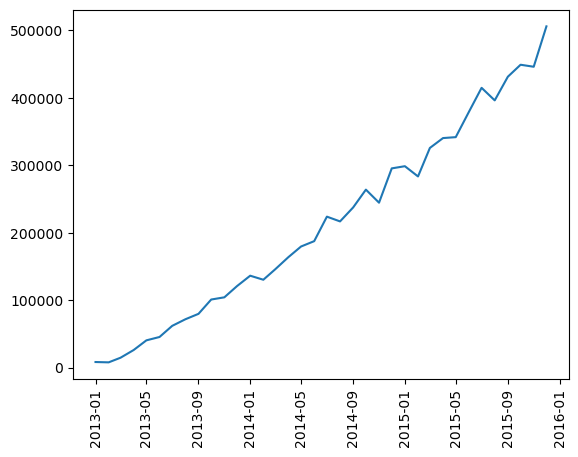

In [28]:
x = Train_data.index
plt.xticks(rotation=90)
plt.plot(Train_data)

In [29]:
#Carrying out statistical tests to check suitability of data for forecasting
RollingMean=Train_data.rolling(window=12).mean()
Rollingstd=Train_data.rolling(window=12).std()

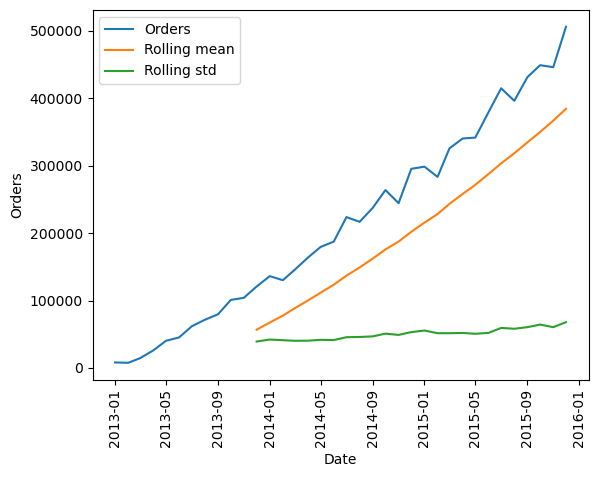

In [31]:
#Plotting rolling figures against orders data
plt.plot(Train_data,label='Orders')
plt.plot(RollingMean,label='Rolling mean')
plt.plot(Rollingstd,label='Rolling std')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Orders')
plt.xticks(rotation=90)
plt.show()

In [32]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(Train_data,autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of observations used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
    
    print(dfoutput)

Test Statistic                  3.587773
p-value                         1.000000
#lags used                     10.000000
Number of observations used    25.000000
Critical Value (1%)            -3.723863
dtype: float64
Test Statistic                  3.587773
p-value                         1.000000
#lags used                     10.000000
Number of observations used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
dtype: float64
Test Statistic                  3.587773
p-value                         1.000000
#lags used                     10.000000
Number of observations used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
